In [1]:
# **Imports**
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Loading and Preparing the data

## Loading the Data 

In [3]:
# uploading the files to GC in order to use them. If you use the file in GCP more often, use a DIFFERENT method like connecting to your Drive, like shown below.
#from google.colab import files
#uploaded1 = files.upload()

In [4]:
#uploaded2 = files.upload()

In [335]:
local_path_target = '/mnt/g/Meine Ablage/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/wind_hourly_clean.csv"

data_target = pd.read_csv(local_path_target)
data_feature = pd.read_csv(local_path_feature)

#data_target = pd.read_csv('/content/drive/MyDrive/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv')
#data_feature = pd.read_csv('/content/drive/MyDrive/raw_data/Features/DATAFRAMES/hourly_globalradiation_df.csv', index_col=0)

data_target['Date'] = pd.to_datetime(data_target.Date)

In [336]:
generation_df = data_target.groupby(by=data_target['Date']).sum()
generation_df.head(3)

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0


In [337]:
wind_df = generation_df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
wind_df.tail(3)

Date
2021-06-16 21:00:00    0.0
2021-06-16 22:00:00    0.0
2021-06-16 23:00:00    0.0
dtype: float64

In [6]:
wind_onshore_df = generation_df["Wind onshore[MWh]"]
wind_onshore_df.head(3)

Date
2015-01-01 00:00:00    8129.0
2015-01-01 01:00:00    8300.0
2015-01-01 02:00:00    8544.0
Name: Wind onshore[MWh], dtype: float64

In [7]:
wind_offshore_df = generation_df["Wind offshore[MWh]"]
wind_offshore_df.head(3)

Date
2015-01-01 00:00:00    517.0
2015-01-01 01:00:00    516.0
2015-01-01 02:00:00    514.0
Name: Wind offshore[MWh], dtype: float64

In [8]:
data_feature.tail(3)

,Date,90,125,161,164,183,197,198,232,282,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
55485,2021-04-30 21:00:00,0.9,0.8,1.1,1.9,2.9,0.6,1.6,2.7,1.3,...,2.4,1.4,2.7,2.4,1.4,1.2,1.6,1.7,1.1,1.2
55486,2021-04-30 22:00:00,0.7,0.7,3.1,1.7,1.1,0.7,1.3,2.6,1.3,...,2.0,3.8,3.0,2.8,1.3,1.1,0.9,1.1,0.9,1.7
55487,2021-04-30 23:00:00,0.5,0.9,1.8,1.4,1.9,1.6,1.8,2.2,1.0,...,2.2,3.6,3.3,2.0,1.2,1.6,0.7,1.4,0.7,2.0


# Statistical Exploration

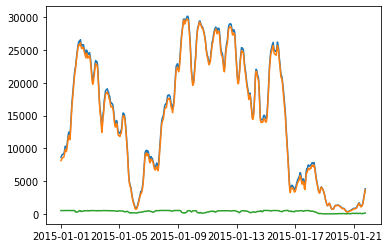

In [9]:
plt.plot(wind_df[:500])
plt.plot(wind_onshore_df[:500])
plt.plot(wind_offshore_df[:500])

<AxesSubplot:>

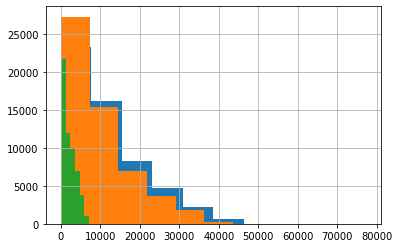

In [10]:
wind_df.hist()
wind_onshore_df.hist()
wind_offshore_df.hist()

<function matplotlib.pyplot.show(close=None, block=None)>

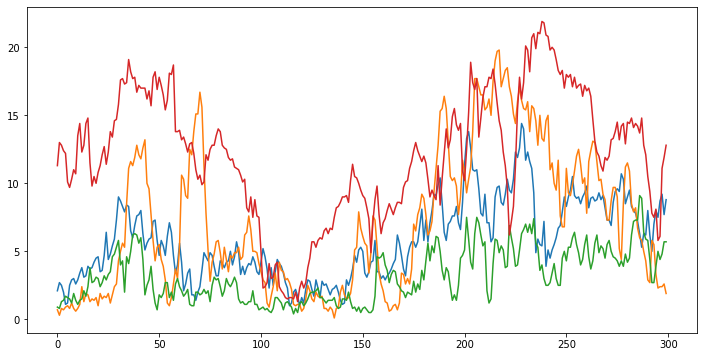

In [347]:
plt.figure(figsize=(12,6))

plt.plot(data_feature["90"][:300])
plt.plot(data_feature["125"][:300])
plt.plot(data_feature["161"][:300])
#plt.plot(data_feature["164"][:300])
plt.plot(data_feature["183"][:300])

plt.show


In [11]:
# p-value (should be less than 0.05 to be sattionary)
from statsmodels.tsa.stattools import adfuller
adfuller(wind_df)[1], adfuller(wind_onshore_df)[1], adfuller(wind_offshore_df)[1]

(7.922097108950382e-30, 4.6242738858550056e-30, 1.7119979669373981e-28)

In [12]:
# Analyzing seasonality and 

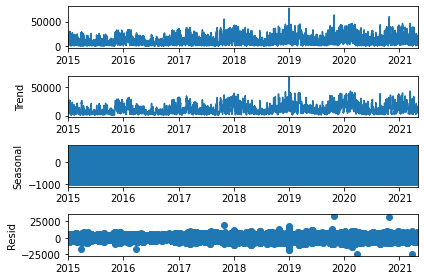

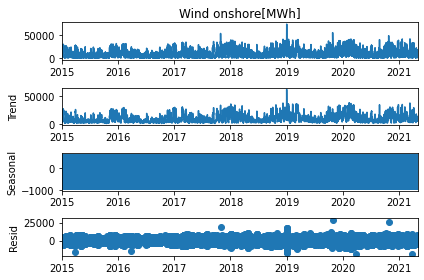

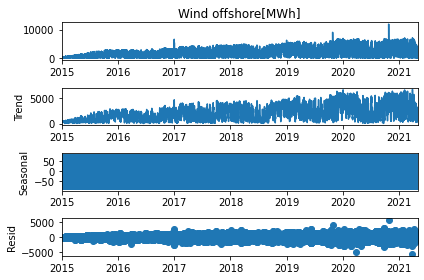

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add_wind = seasonal_decompose(wind_df, model='additive')
result_add_wind.plot()
result_add_wind_on = seasonal_decompose(wind_onshore_df, model='additive')
result_add_wind_on.plot()
result_add_wind_off = seasonal_decompose(wind_offshore_df, model='additive')
result_add_wind_off.plot();

# Preparing the Data




### Concatenating the Data

In [17]:
#wind_df.drop(wind_df.head(wind_df.shape[0]-data_feature.shape[0]).index,inplace=True)

In [18]:
# Building one DataFrame to make the correlation Analysis

complete_df = pd.concat([wind_df, data_feature.set_index(wind_df.index)], axis=1)
complete_df.shape

(55488, 262)

### Filtering the data with highly correlated timeseries Optional 

In [17]:
# Correlation Analysis
#complete_df.corr()

In [19]:
df_corr = complete_df.corr().abs()

In [20]:
df_corr

,0,90,125,161,164,183,197,198,232,282,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
0,1.000000,0.672867,0.393442,0.426537,0.583885,0.550089,0.656112,0.621847,0.440282,0.442417,...,0.668633,0.409030,0.725860,0.576956,0.623224,0.679716,0.492999,0.237522,0.371679,0.594521
90,0.672867,1.000000,0.543547,0.612504,0.500168,0.341446,0.706722,0.701895,0.604027,0.656348,...,0.708743,0.535634,0.710527,0.723858,0.529634,0.693645,0.636308,0.320410,0.541895,0.608516
125,0.393442,0.543547,1.000000,0.413092,0.333832,0.179391,0.363276,0.457304,0.742461,0.523947,...,0.414600,0.386806,0.406578,0.653900,0.315894,0.332954,0.417515,0.479192,0.656768,0.439267
161,0.426537,0.612504,0.413092,1.000000,0.362323,0.177979,0.569918,0.561275,0.504783,0.605232,...,0.517936,0.818226,0.537571,0.550638,0.391706,0.484871,0.639278,0.268681,0.539696,0.450367
164,0.583885,0.500168,0.333832,0.362323,1.000000,0.600312,0.470414,0.588639,0.372283,0.467946,...,0.340588,0.310142,0.470688,0.441865,0.797376,0.333188,0.463722,0.165017,0.335227,0.762633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15200,0.679716,0.693645,0.332954,0.484871,0.333188,0.295231,0.678224,0.463587,0.389272,0.407271,...,0.821111,0.416191,0.734160,0.532210,0.402222,1.000000,0.426264,0.198109,0.337712,0.377732
15207,0.492999,0.636308,0.417515,0.639278,0.463722,0.236359,0.651856,0.630654,0.512979,0.641372,...,0.449854,0.631367,0.601151,0.570253,0.467443,0.426264,1.000000,0.260604,0.512547,0.571384
15214,0.237522,0.320410,0.479192,0.268681,0.165017,0.082890,0.228603,0.268698,0.443158,0.328265,...,0.258908,0.254703,0.223473,0.369785,0.144194,0.198109,0.260604,1.000000,0.396564,0.234382
15444,0.371679,0.541895,0.656768,0.539696,0.335227,0.158540,0.420880,0.516589,0.765865,0.650644,...,0.432803,0.463258,0.438031,0.664564,0.335440,0.337712,0.512547,0.396564,1.000000,0.437344


In [21]:
sorted_corr = df_corr.iloc[0].sort_values(ascending=False)
pd.DataFrame(sorted_corr)

,0
0,1.000000
722,0.802293
2483,0.759344
2932,0.742030
1503,0.740801
...,...
15214,0.237522
5800,0.224589
6103,0.215340
3730,0.125638


In [266]:
list_of_corr_060 = list(sorted_corr[sorted_corr >= 0.2].index)

In [267]:
filtered_df = complete_df[list_of_corr_060]

In [268]:
filtered_df.shape

(55488, 259)

## Getting the weather stations lat & long

In [269]:
local_path_station_metadata = "/mnt/g/Meine Ablage/raw_data/Features/DATAFRAMES/stations_metadata.csv"

station_meta_list = pd.read_csv(local_path_station_metadata, dtype="str")

In [270]:
station_meta_list.head()

,Stationsname,Stations_ID,Kennung,Stations-\nkennung,Breite,Länge,Stations-\nhöhe,Flussgebiet,Bundesland,Beginn,Ende
0,Aach,1,KL,2783,47.841,8.849,478,NaN,BW,01.01.1937,30.06.1986
1,Aach,1,RR,70191,47.841,8.849,478,NaN,BW,01.01.1912,30.06.1986
2,Aach/Hegau,10771,PE,10771,47.85,8.85,480,NaN,BW,NaN,NaN
3,Aachen,3,EB,2205,507.827,6.0941,202,803100,NW,01.01.1951,31.03.2011
4,Aachen,3,FF,2205,507.827,6.0941,202,803100,NW,01.01.1937,31.03.2011


In [271]:
station_meta_list = station_meta_list.drop_duplicates("Stations_ID")

In [272]:
station_ids = list_of_corr_040[1:]

NameError: name 'list_of_corr_040' is not defined

In [273]:
wind_stations_lat_lon = station_meta_list[station_meta_list["Stations_ID"].isin(station_ids)]

In [274]:
type(temp_dict)

list

### Scaling the Data

In [275]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(filtered_df)

In [276]:
scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(pd.DataFrame(wind_df))

In [277]:
np.asmatrix(scaled)

matrix([[0.11213717, 0.34300792, 0.34123223, ..., 0.05988024, 0.056     ,
         0.2       ],
        [0.11434204, 0.37467018, 0.2985782 , ..., 0.05389222, 0.04      ,
         0.09142857],
        [0.11748074, 0.34564644, 0.30805687, ..., 0.09580838, 0.048     ,
         0.05714286],
        ...,
        [0.0248502 , 0.03957784, 0.12796209, ..., 0.08982036, 0.488     ,
         0.20571429],
        [0.02658816, 0.09234828, 0.13270142, ..., 0.05389222, 0.4       ,
         0.20571429],
        [0.02896164, 0.06860158, 0.14218009, ..., 0.07185629, 0.416     ,
         0.21714286]])

### Testing Granger Causality per weather station

In [278]:
from statsmodels.tsa.stattools import grangercausalitytests

In [296]:
temp_df = pd.concat((pd.DataFrame(scaled[int(len(scaled)*0.5):int(len(scaled)-test_length),:1]), pd.DataFrame(scaled[int(len(scaled)*0.5):int(len(scaled)-test_length),258:])),axis=1)

In [298]:
scaled[int(len(scaled)*0.5):int(len(scaled)-test_length),259:]

array([], shape=(27648, 0), dtype=float64)

In [297]:
gc_res = grangercausalitytests(temp_df,1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2866  , p=0.2567  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=1.2868  , p=0.2566  , df=1
likelihood ratio test: chi2=1.2867  , p=0.2566  , df=1
parameter F test:         F=1.2866  , p=0.2567  , df_denom=27644, df_num=1


In [281]:
scaled[int(len(scaled)*0.5):int(len(scaled)-test_length),:1].shape

(27648, 1)

In [282]:
gc_res[1]

({'ssr_ftest': (2.7811724137805305, 0.09538965145497046, 27644.0, 1),
  'ssr_chi2test': (2.781474233967238, 0.09536035383358708, 1),
  'lrtest': (2.781334325845819, 0.09536868386552676, 1),
  'params_ftest': (2.781172413803067, 0.09538965145345527, 27644.0, 1.0)},
  array([[0., 1., 0.]])])

In [283]:
gc_res[1][0]['ssr_ftest'][1],gc_res[1][0]['ssr_chi2test'][1],gc_res[1][0]['lrtest'][1],gc_res[1][0]['params_ftest'][1]

(0.09538965145497046,
 0.09536035383358708,
 0.09536868386552676,
 0.09538965145345527)

In [284]:
scaled.shape[1]-1

258

In [285]:
def testing_granger_cause(range_l):
    good_stations = []
    bad_stations = []
    for index in range_l:
        temp_df = pd.concat((pd.DataFrame(scaled[int(len(scaled)*0.5):int(len(scaled)-test_length),:1]), 
                   pd.DataFrame(scaled[int(len(scaled)*0.5):int(len(scaled)-test_length),(index):(index+1)])),axis=1)
        gc_res = grangercausalitytests(temp_df,1)
        if (gc_res[1][0]['ssr_ftest'][1] + 
            gc_res[1][0]['ssr_chi2test'][1] + 
            gc_res[1][0]['lrtest'][1] + 
            gc_res[1][0]['params_ftest'][1]) < 0.2:
            good_stations.append(index)
        else:
            bad_stations.append(index)
    return good_stations, bad_stations

In [310]:
good_stations, bad_stations = testing_granger_cause(range(1,(scaled.shape[1]-1)))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=250.1487, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=250.1758, p=0.0000  , df=1
likelihood ratio test: chi2=249.0507, p=0.0000  , df=1
parameter F test:         F=250.1487, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=559.2488, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=559.3095, p=0.0000  , df=1
likelihood ratio test: chi2=553.7271, p=0.0000  , df=1
parameter F test:         F=559.2488, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7146  , p=0.0055  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=7.7155  , p=0.0055  , df=1
likelihood ratio test: chi2=7.7144  , p=0.0055  , df=1
parameter F test:         F=7.7146  , p=0.0055  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=762.2799

ssr based F test:         F=4.6643  , p=0.0308  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=4.6648  , p=0.0308  , df=1
likelihood ratio test: chi2=4.6644  , p=0.0308  , df=1
parameter F test:         F=4.6643  , p=0.0308  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=56.1974 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=56.2035 , p=0.0000  , df=1
likelihood ratio test: chi2=56.1465 , p=0.0000  , df=1
parameter F test:         F=56.1974 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=112.5059, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=112.5181, p=0.0000  , df=1
likelihood ratio test: chi2=112.2898, p=0.0000  , df=1
parameter F test:         F=112.5059, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=78.0086 , p=0.0000  , df_denom=27644, df_num=1
ssr bas

ssr based F test:         F=3.0316  , p=0.0817  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=3.0319  , p=0.0816  , df=1
likelihood ratio test: chi2=3.0317  , p=0.0817  , df=1
parameter F test:         F=3.0316  , p=0.0817  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=74.1283 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=74.1364 , p=0.0000  , df=1
likelihood ratio test: chi2=74.0372 , p=0.0000  , df=1
parameter F test:         F=74.1283 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.4338 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=34.4375 , p=0.0000  , df=1
likelihood ratio test: chi2=34.4161 , p=0.0000  , df=1
parameter F test:         F=34.4338 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=632.3177, p=0.0000  , df_denom=27644, df_num=1
ssr bas

ssr based F test:         F=36.5660 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=36.5699 , p=0.0000  , df=1
likelihood ratio test: chi2=36.5458 , p=0.0000  , df=1
parameter F test:         F=36.5660 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=122.3232, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=122.3364, p=0.0000  , df=1
likelihood ratio test: chi2=122.0666, p=0.0000  , df=1
parameter F test:         F=122.3232, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=482.8740, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=482.9264, p=0.0000  , df=1
likelihood ratio test: chi2=478.7571, p=0.0000  , df=1
parameter F test:         F=482.8740, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=133.4616, p=0.0000  , df_denom=27644, df_num=1
ssr bas

ssr based F test:         F=0.2735  , p=0.6010  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=0.2735  , p=0.6010  , df=1
likelihood ratio test: chi2=0.2735  , p=0.6010  , df=1
parameter F test:         F=0.2735  , p=0.6010  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=414.4950, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=414.5400, p=0.0000  , df=1
likelihood ratio test: chi2=411.4629, p=0.0000  , df=1
parameter F test:         F=414.4950, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=47.0442 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=47.0493 , p=0.0000  , df=1
likelihood ratio test: chi2=47.0094 , p=0.0000  , df=1
parameter F test:         F=47.0442 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=96.7048 , p=0.0000  , df_denom=27644, df_num=1
ssr bas


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=85.6385 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=85.6478 , p=0.0000  , df=1
likelihood ratio test: chi2=85.5154 , p=0.0000  , df=1
parameter F test:         F=85.6385 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=118.6547, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=118.6675, p=0.0000  , df=1
likelihood ratio test: chi2=118.4136, p=0.0000  , df=1
parameter F test:         F=118.6547, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=161.4504, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=161.4679, p=0.0000  , df=1
likelihood ratio test: chi2=160.9982, p=0.0000  , df=1
parameter F test:         F=161.4504, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=221.7170

ssr based F test:         F=23.5409 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=23.5434 , p=0.0000  , df=1
likelihood ratio test: chi2=23.5334 , p=0.0000  , df=1
parameter F test:         F=23.5409 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=57.6414 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=57.6476 , p=0.0000  , df=1
likelihood ratio test: chi2=57.5876 , p=0.0000  , df=1
parameter F test:         F=57.6414 , p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=290.4183, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=290.4498, p=0.0000  , df=1
likelihood ratio test: chi2=288.9347, p=0.0000  , df=1
parameter F test:         F=290.4183, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=158.9467, p=0.0000  , df_denom=27644, df_num=1
ssr bas

likelihood ratio test: chi2=138.1974, p=0.0000  , df=1
parameter F test:         F=138.5283, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=138.4022, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=138.4173, p=0.0000  , df=1
likelihood ratio test: chi2=138.0719, p=0.0000  , df=1
parameter F test:         F=138.4022, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=193.6519, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=193.6729, p=0.0000  , df=1
likelihood ratio test: chi2=192.9977, p=0.0000  , df=1
parameter F test:         F=193.6519, p=0.0000  , df_denom=27644, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=153.8187, p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=153.8354, p=0.0000  , df=1
likelihood ratio test: chi2=153.4090, p=0.0000  , df=1
parameter F test:         F

ssr based F test:         F=19.4074 , p=0.0000  , df_denom=27644, df_num=1
ssr based chi2 test:   chi2=19.4095 , p=0.0000  , df=1
likelihood ratio test: chi2=19.4027 , p=0.0000  , df=1
parameter F test:         F=19.4074 , p=0.0000  , df_denom=27644, df_num=1


In [311]:
bad_stations.append(258)

### Filtering and scaling new

In [314]:
filtered_df.drop(filtered_df.columns[bad_stations],axis=1,inplace=True)

/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [316]:
filtered_df

,0,722,2483,2932,1503,6091,5715,342,1270,15120,...,6099,856,2377,5412,6211,6107,1490,6102,15214,5800
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,8646.0,13.5,7.6,3.4,3.3,6.9,4.1,3.9,4.0,4.9,...,3.4,0.8,0.8,4.1,0.5,3.3,3.9,3.2,1.2,0.7
2015-01-01 01:00:00,8816.0,14.7,6.7,3.1,4.0,6.9,4.0,3.2,4.1,5.3,...,1.7,1.6,1.2,3.7,0.9,3.7,3.7,2.2,1.1,0.5
2015-01-01 02:00:00,9058.0,13.6,6.9,4.0,4.4,6.9,4.8,3.4,4.3,4.8,...,1.0,1.2,1.7,4.5,1.1,3.8,2.8,1.8,1.8,0.6
2015-01-01 03:00:00,9071.0,13.0,7.2,4.3,4.7,6.9,5.0,3.5,3.7,4.2,...,0.8,1.8,1.1,3.9,1.3,4.1,2.4,2.2,1.1,0.5
2015-01-01 04:00:00,9168.0,14.4,7.9,4.0,4.8,6.9,3.8,2.6,2.7,4.1,...,0.6,1.3,1.3,4.4,1.0,3.9,3.1,3.3,0.9,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 19:00:00,1297.0,2.0,2.5,1.6,3.6,2.6,2.3,1.2,2.6,1.3,...,1.3,4.9,2.0,1.0,6.7,1.6,1.8,1.8,1.6,6.1
2021-04-30 20:00:00,1471.0,1.7,2.7,1.8,3.6,2.6,2.2,1.3,2.0,1.8,...,1.2,6.7,2.3,1.0,3.3,1.4,3.4,1.7,1.3,7.9
2021-04-30 21:00:00,1916.0,2.0,3.1,1.3,3.6,2.9,0.8,1.1,1.7,2.7,...,0.8,5.3,1.2,1.3,2.8,1.3,3.2,1.9,1.7,6.1


In [317]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(filtered_df)

# Sarimax Model

## Forming sequences

In [318]:
test_length = 96

In [319]:
# Train_Data
trainX2 = scaled[int(len(scaled)*0.5):int(len(scaled)-test_length),1:]
trainy2 = scaled_y[int(len(scaled_y)*0.5):int(len(scaled)-test_length),:]
# validation Data
testX2 = scaled[int(len(scaled)-96):,1:]
testy2 = scaled_y[int(len(scaled)-96):,:]

In [320]:
trainX2.shape, trainy2.shape

((27648, 240), (27648, 1))

In [321]:
testX2.shape, testy2.shape

((96, 240), (96, 1))

## Training and predicting with the Model

In [322]:
# Findng the Hyp
#import pmdarima as pm

#smodel = pm.auto_arima(trainy, m=12, X=trainX,
                       #start_p=0, max_p=2,
                       #start_q=0, max_q=5,
                       #max_P=2, max_D=1,max_Q=2,
                       #seasonal=True,
                       #trace=True)

In [323]:
# Order Parameters of best model with exog wind speed and hourly data, non logarithmic data
bm_order = (0,1,0)
# could choose also 24  because sun always has a daily cycle
bm_seasonal_order = (0,0,0,24)

In [324]:
# The model
sarimax = SARIMAX(endog=trainy2, exog=trainX2, order=bm_order, seasonal_order=bm_seasonal_order ).fit()

/home/hauke/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [325]:
#Forecasting
y_pred = sarimax.forecast(testy2.shape[0], exog=testX2, alpha=0.05)

## Unscaling results

In [326]:
unscaling_array_2 = scaled_y[:len(scaled_y)-y_pred.shape[0]]

In [327]:
unscaling_array_tog = np.append(unscaling_array_2,y_pred.flatten().reshape(-1,1), axis=0)

In [328]:
unscaled_results = scaler_y.inverse_transform(unscaling_array_tog)

## MSE & PLot of results

In [329]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [330]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(20,8), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

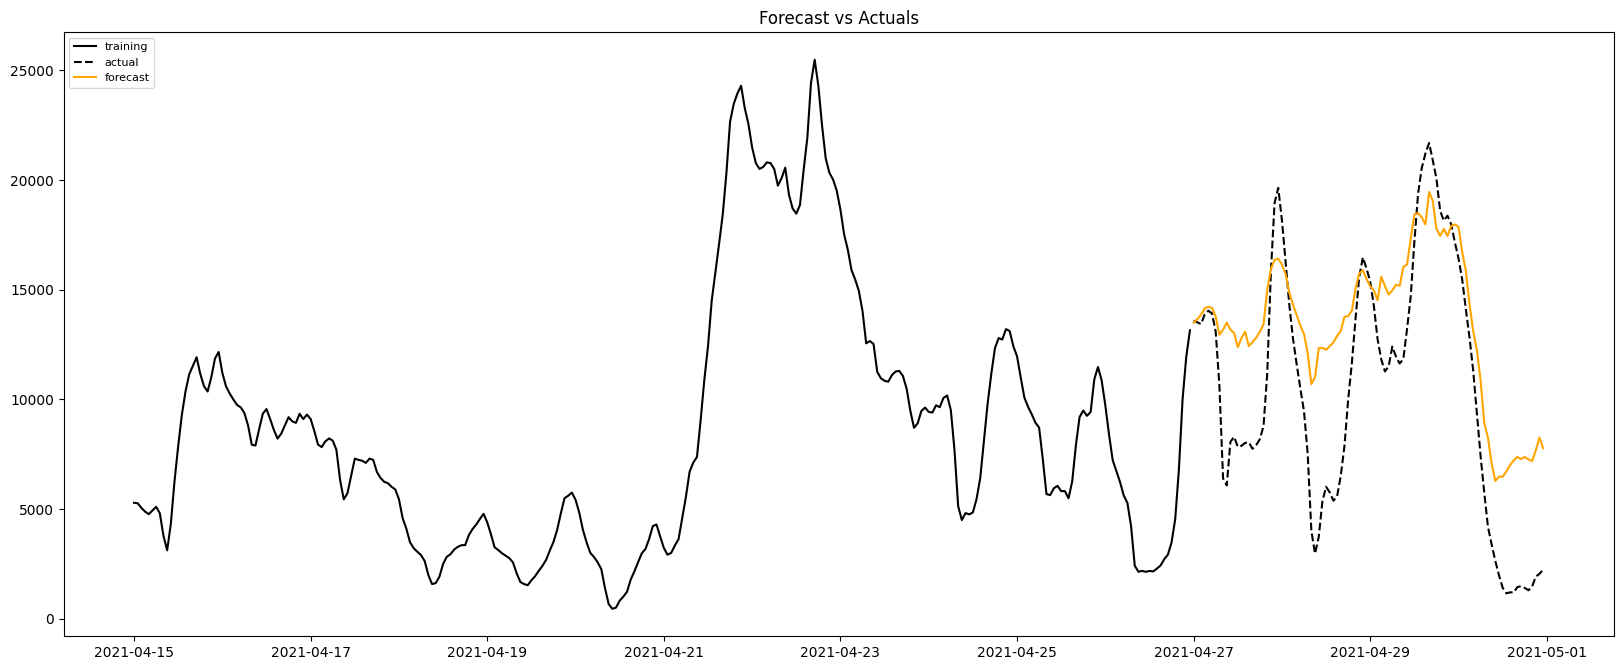

In [331]:
plot_forecast(unscaled_results[len(unscaled_results)-test_length:].flatten()
    , wind_df[len(wind_df)-(test_length*4):len(wind_df)-test_length], wind_df[len(wind_df)-test_length:])

In [332]:
mean_absolute_percentage_error(wind_df[len(wind_df)-test_length:], unscaled_results[len(unscaled_results)-test_length:].flatten())

88.59897556802565

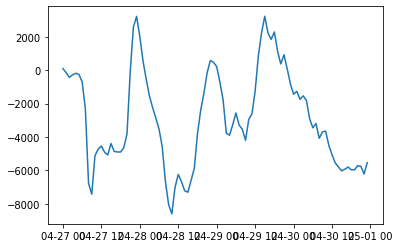

In [333]:
# plotting the residuals

plt.plot(wind_df[len(wind_df)-test_length:] - unscaled_results[len(unscaled_results)-test_length:].flatten())

Things to try out:
Splitting onshore and offshore wind generation, vary the timeframe of wind_data, excluding a lot of timeseries and just include the most representative for the region, 

GEt the feature importance of the weather station time series?

Get the best timeframe to sow in the presentation